# Introduction

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [47]:
import numpy as np
import pandas as pd

import math

import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.metrics
from sklearn.neighbors import NearestNeighbors
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [48]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [49]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [50]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
2194,1,28.0,43900.0,0,0
2446,0,22.0,39200.0,2,0
557,0,32.0,23100.0,2,0
4962,0,49.0,32500.0,1,2
1073,1,44.0,57300.0,0,1
2759,0,47.0,41000.0,3,1
87,0,28.0,45900.0,0,0
2590,0,38.0,40200.0,0,0
49,0,28.0,36600.0,1,0
3963,1,36.0,40600.0,1,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [52]:
# we may want to fix the age type (from float to int) though this is not critical
# write your conversion here if you choose:
df['age'] = df['age'].astype(int)


In [53]:
# check to see that the conversion was successful
df.dtypes

gender                  int64
age                     int64
income                float64
family_members          int64
insurance_benefits      int64
dtype: object

In [54]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


<AxesSubplot:xlabel='age', ylabel='Density'>

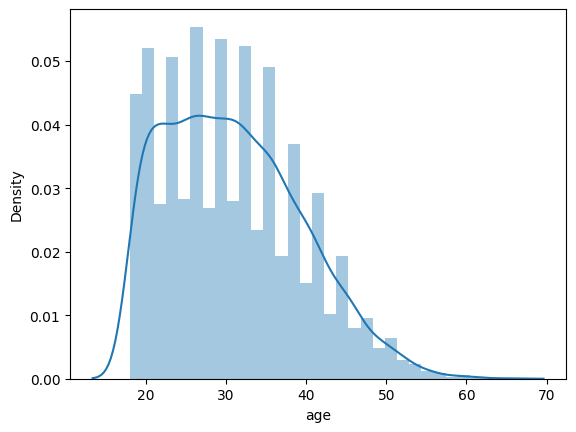

In [55]:
sns.distplot(df['age'])

<AxesSubplot:xlabel='income', ylabel='Density'>

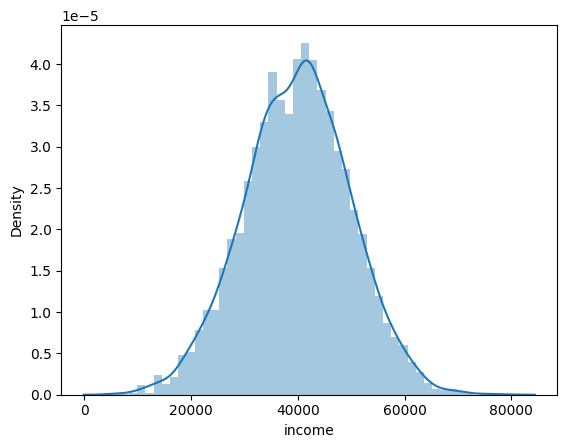

In [56]:
sns.distplot(df['income'])

Looking at our descriptive stats for our dataframe, we see that the mean and median ages are the same. The income is slightly negatively skewed. There are also no missing or null values found with 5000 entries.

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

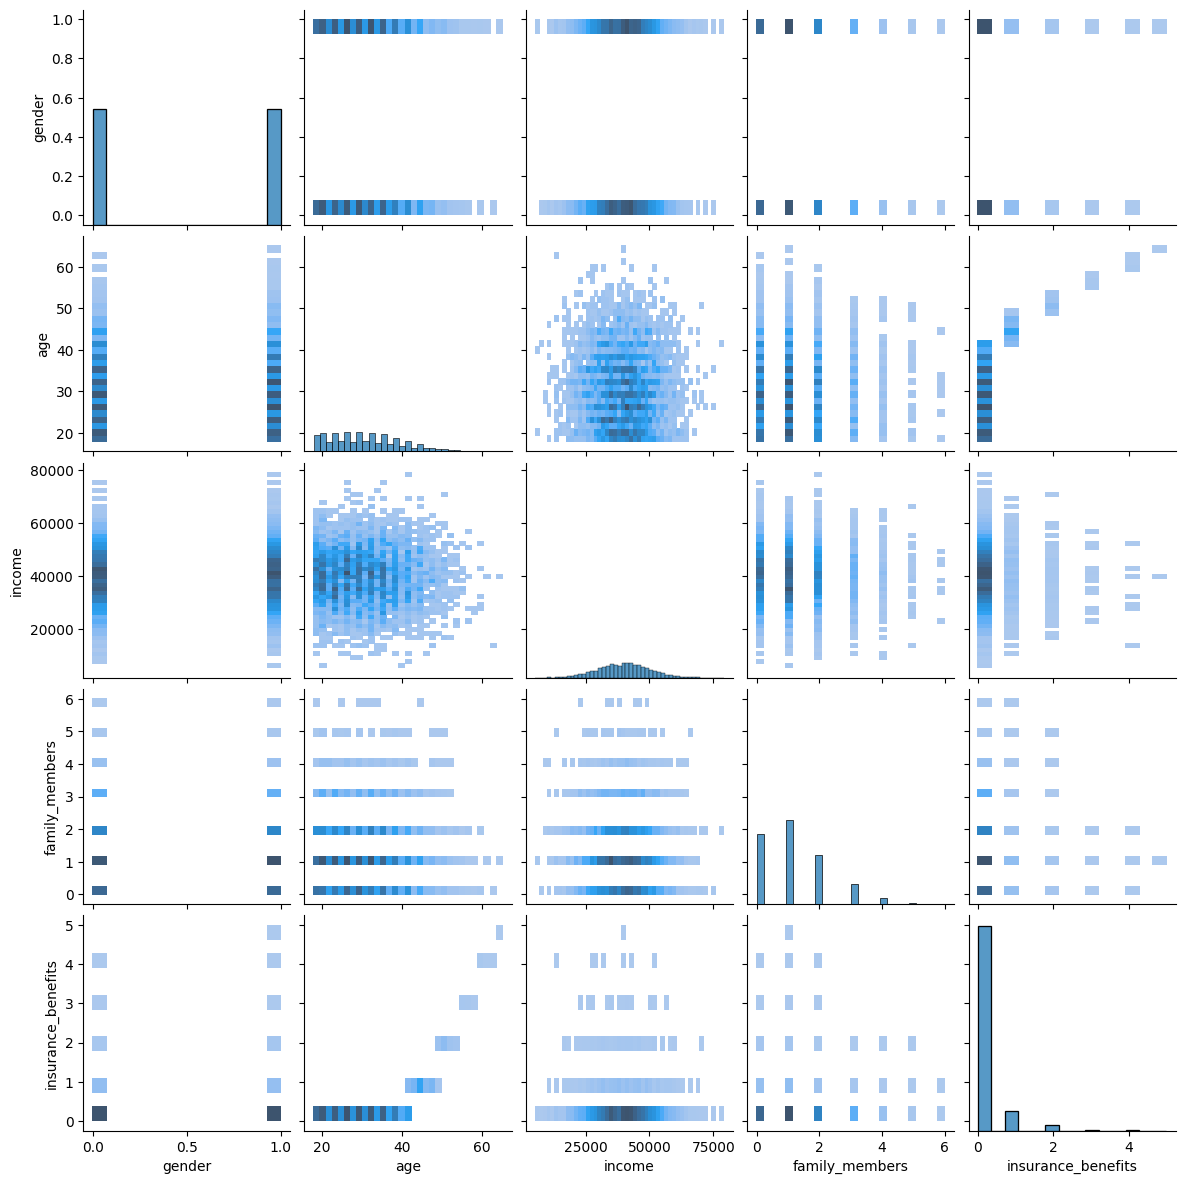

In [57]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [58]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [59]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric=metric) 
    nbrs.fit(df[feature_names].values)
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Scaling the data.

In [60]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [61]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3733,1.0,0.492308,0.583544,0.166667,0
3543,1.0,0.430769,0.703797,0.333333,0
985,0.0,0.569231,0.293671,0.000000,0
3988,1.0,0.369231,0.446835,0.000000,0
3975,1.0,0.384615,0.469620,0.333333,0


Now, let's get similar records for a given one for every combination

In [62]:
manhattan_scaled = get_knn(df_scaled, 4, 7, 'manhattan')
manhattan_scaled

,gender,age,income,family_members,insurance_benefits,distance
4,1.0,0.430769,0.330380,0.0,0,0.000000
349,1.0,0.430769,0.322785,0.0,0,0.007595
3934,1.0,0.430769,0.321519,0.0,0,0.008861
3665,1.0,0.430769,0.317722,0.0,0,0.012658
1435,1.0,0.446154,0.331646,0.0,0,0.016650
2448,1.0,0.446154,0.324051,0.0,0,0.021714
1774,1.0,0.400000,0.331646,0.0,0,0.032035


In [63]:
euclidean_scaled = get_knn(df_scaled, 4, 7, 'euclidean')
euclidean_scaled

,gender,age,income,family_members,insurance_benefits,distance
4,1.0,0.430769,0.330380,0.0,0,0.000000
349,1.0,0.430769,0.322785,0.0,0,0.007595
3934,1.0,0.430769,0.321519,0.0,0,0.008861
3665,1.0,0.430769,0.317722,0.0,0,0.012658
1435,1.0,0.446154,0.331646,0.0,0,0.015437
2448,1.0,0.446154,0.324051,0.0,0,0.016636
1401,1.0,0.446154,0.351899,0.0,0,0.026453


In [64]:
man_not_scaled = get_knn(df, 4, 7, 'manhattan')
man_not_scaled

,gender,age,income,family_members,insurance_benefits,distance
4,1,28,26100.0,0,0,0.0
2701,1,31,26100.0,3,0,6.0
2773,1,24,26100.0,2,0,6.0
3346,0,34,26100.0,0,0,7.0
4721,1,22,26100.0,2,0,8.0
1507,1,35,26100.0,2,0,9.0
3462,0,35,26100.0,2,0,10.0


In [65]:
euc_not_scaled = get_knn(df, 4, 7, 'euclidean')
euc_not_scaled

,gender,age,income,family_members,insurance_benefits,distance
4,1,28,26100.0,0,0,0.000000
2701,1,31,26100.0,3,0,4.242641
2773,1,24,26100.0,2,0,4.472136
3346,0,34,26100.0,0,0,6.082763
4721,1,22,26100.0,2,0,6.324555
1507,1,35,26100.0,2,0,7.280110
3462,0,35,26100.0,2,0,7.348469


Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 
Below the graphs show the results between scaled v. unscaled data. The kNN algorithim is influenced by the data not being scaled because the algorithim favors higher ranging numbers. Since we have to choose the K number of samer for the predictions causes an impact on our results. The result of us choosing K, makes large features favored during prediction which in turn affects distance computation.

array([[<AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'family_members'}>]], dtype=object)

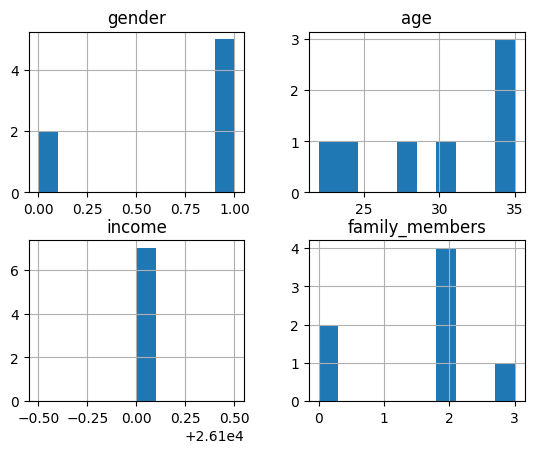

In [66]:
man_not_scaled[feature_names].hist()

array([[<AxesSubplot:title={'center':'gender'}>,
        <AxesSubplot:title={'center':'age'}>],
       [<AxesSubplot:title={'center':'income'}>,
        <AxesSubplot:title={'center':'family_members'}>]], dtype=object)

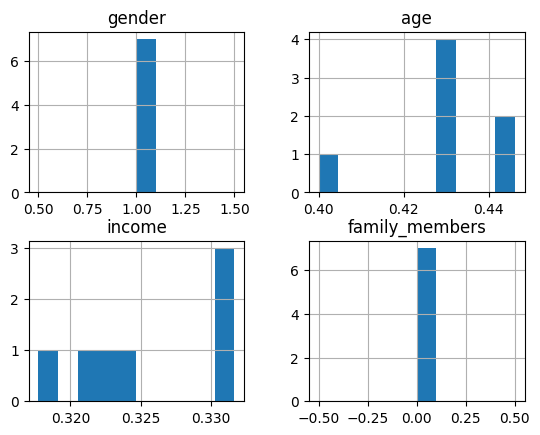

In [67]:
manhattan_scaled[feature_names].hist()

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Text(0, 0.5, 'Frequency')

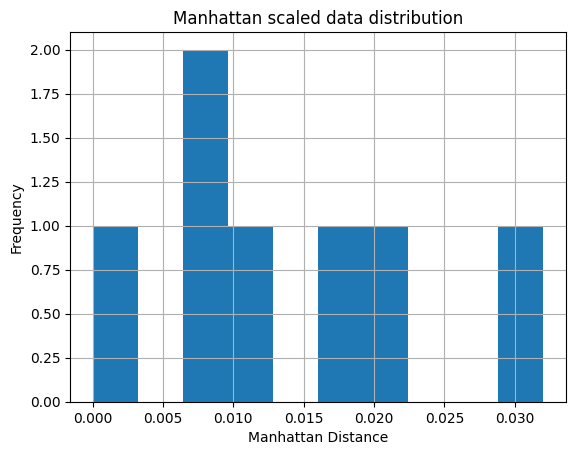

In [68]:
manhattan_scaled.distance.hist()
plt.title('Manhattan scaled data distribution')
plt.xlabel('Manhattan Distance')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

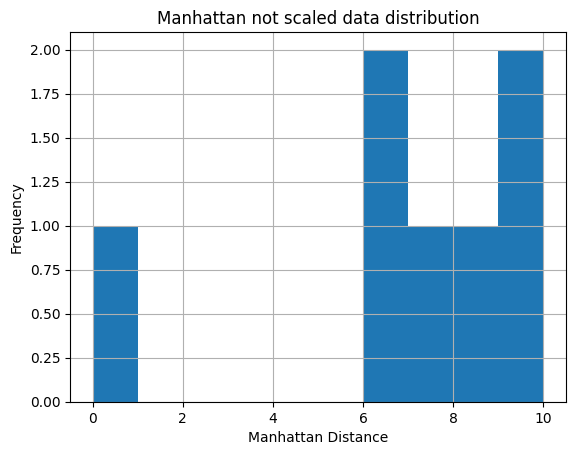

In [69]:
man_not_scaled.distance.hist()
plt.title('Manhattan not scaled data distribution')
plt.xlabel('Manhattan Distance')
plt.ylabel('Frequency')

From the two histograms above displaying the distribution between our manhattan distance when they are scaled vs not scaled, we can see there is an obvious difference .

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [70]:
# calculate the target

df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype(int)

In [71]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts(normalize=True)

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64

In [72]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [73]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [74]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, df[feature_names].shape[0])
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [75]:
train, test = train_test_split(df, test_size=.3, stratify=df['insurance_benefits_received'], random_state=123)
x_train = train[feature_names]
y_train = train['insurance_benefits_received']
x_test = test[feature_names]
y_test = test['insurance_benefits_received']

In [76]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train, y_train)
predict_y = knn.predict(x_test)
eval_classifier(y_test, predict_y)

F1: 0.41
Confusion Matrix
[[0.88       0.00733333]
 [0.082      0.03066667]]


In [77]:
k = np.arange(1,11)
for k in k:
    print('F1 Score, Confusion Matrix for K:')
    knn=KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    predict_y = knn.predict(x_test)
    eval_classifier(y_test, predict_y)
    print()

F1 Score, Confusion Matrix for K:
F1: 0.69
Confusion Matrix
[[0.876      0.01133333]
 [0.04666667 0.066     ]]

F1 Score, Confusion Matrix for K:
F1: 0.38
Confusion Matrix
[[0.88533333 0.002     ]
 [0.08533333 0.02733333]]

F1 Score, Confusion Matrix for K:
F1: 0.41
Confusion Matrix
[[0.88       0.00733333]
 [0.082      0.03066667]]

F1 Score, Confusion Matrix for K:
F1: 0.21
Confusion Matrix
[[8.86666667e-01 6.66666667e-04]
 [9.93333333e-02 1.33333333e-02]]

F1 Score, Confusion Matrix for K:
F1: 0.21
Confusion Matrix
[[0.88333333 0.004     ]
 [0.09866667 0.014     ]]

F1 Score, Confusion Matrix for K:
F1: 0.15
Confusion Matrix
[[0.88733333 0.        ]
 [0.10333333 0.00933333]]

F1 Score, Confusion Matrix for K:
F1: 0.16
Confusion Matrix
[[0.886      0.00133333]
 [0.10266667 0.01      ]]

F1 Score, Confusion Matrix for K:
F1: 0.00
Confusion Matrix
[[0.88733333 0.        ]
 [0.11266667 0.        ]]

F1 Score, Confusion Matrix for K:
F1: 0.01
Confusion Matrix
[[8.87333333e-01 0.00000000e

In [78]:
# With scaled data
df_scaled['insurance_benefits_received'] = df_scaled.insurance_benefits > 0

In [79]:
target = df_scaled['insurance_benefits_received']
features = df_scaled[feature_names]

x_train,x_test,y_train,y_test = train_test_split(features,target, 
                                                 test_size=.3, random_state=123)

In [80]:
k = np.arange(1,11)
for k in k:
    print('Scaled data F1 score and confusion matrix: ')
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    eval_classifier(y_test, knn.predict(x_test))
    print()

Scaled data F1 score and confusion matrix: 
F1: 0.95
Confusion Matrix
[[0.88266667 0.004     ]
 [0.00733333 0.106     ]]

Scaled data F1 score and confusion matrix: 
F1: 0.92
Confusion Matrix
[[8.86000000e-01 6.66666667e-04]
 [1.53333333e-02 9.80000000e-02]]

Scaled data F1 score and confusion matrix: 
F1: 0.93
Confusion Matrix
[[0.88533333 0.00133333]
 [0.01266667 0.10066667]]

Scaled data F1 score and confusion matrix: 
F1: 0.90
Confusion Matrix
[[0.88666667 0.        ]
 [0.02066667 0.09266667]]

Scaled data F1 score and confusion matrix: 
F1: 0.92
Confusion Matrix
[[0.88333333 0.00333333]
 [0.01333333 0.1       ]]

Scaled data F1 score and confusion matrix: 
F1: 0.93
Confusion Matrix
[[0.88666667 0.        ]
 [0.01533333 0.098     ]]

Scaled data F1 score and confusion matrix: 
F1: 0.94
Confusion Matrix
[[0.88533333 0.00133333]
 [0.01133333 0.102     ]]

Scaled data F1 score and confusion matrix: 
F1: 0.93
Confusion Matrix
[[0.88666667 0.        ]
 [0.01466667 0.09866667]]

Scaled d

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [81]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = (np.linalg.inv(X2.T.dot(X2))).dot(X2.T).dot(y)
         

    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [82]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [83]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


The model returned a RMSE = .34 and R2 = .66

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [84]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [85]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [86]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [87]:
y = np.linalg.inv(P)
P.dot(y)

array([[ 1.00000000e+00, -1.69848573e-16, -7.58122972e-17,
        -1.13112497e-16],
       [-6.94895396e-17,  1.00000000e+00, -7.10568689e-17,
         3.59096970e-17],
       [-1.21269339e-16, -8.01461326e-17,  1.00000000e+00,
         4.30764008e-19],
       [-3.60694539e-16, -5.55430227e-16,  3.08072404e-16,
         1.00000000e+00]])

Can you guess the customers' ages or income after the transformation?

In [88]:
X_prime = np.matmul(X,P)
X_prime

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [89]:
X_reverse = X_prime @ np.linalg.inv(P)
X_reverse

array([[ 1.00000000e+00,  4.10000000e+01,  4.96000000e+04,
         1.00000000e+00],
       [-4.47363596e-12,  4.60000000e+01,  3.80000000e+04,
         1.00000000e+00],
       [-2.51586878e-12,  2.90000000e+01,  2.10000000e+04,
         9.52452315e-13],
       ...,
       [-1.92837871e-12,  2.00000000e+01,  3.39000000e+04,
         2.00000000e+00],
       [ 1.00000000e+00,  2.20000000e+01,  3.27000000e+04,
         3.00000000e+00],
       [ 1.00000000e+00,  2.80000000e+01,  4.06000000e+04,
         1.00000000e+00]])

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [90]:
print(X)
print(X_prime)
print(X_reverse)

[[1.00e+00 4.10e+01 4.96e+04 1.00e+00]
 [0.00e+00 4.60e+01 3.80e+04 1.00e+00]
 [0.00e+00 2.90e+01 2.10e+04 0.00e+00]
 ...
 [0.00e+00 2.00e+01 3.39e+04 2.00e+00]
 [1.00e+00 2.20e+01 3.27e+04 3.00e+00]
 [1.00e+00 2.80e+01 4.06e+04 1.00e+00]]
[[ 6359.71527314 22380.40467609 18424.09074184 46000.69669016]
 [ 4873.29406479 17160.36702982 14125.78076133 35253.45577301]
 [ 2693.11742928  9486.397744    7808.83156024 19484.86063067]
 ...
 [ 4346.2234249  15289.24126492 12586.16264392 31433.50888552]
 [ 4194.09324155 14751.9910242  12144.02930637 30323.88763426]
 [ 5205.46827354 18314.24814446 15077.01370762 37649.59295455]]
[[ 1.00000000e+00  4.10000000e+01  4.96000000e+04  1.00000000e+00]
 [-4.47363596e-12  4.60000000e+01  3.80000000e+04  1.00000000e+00]
 [-2.51586878e-12  2.90000000e+01  2.10000000e+04  9.52452315e-13]
 ...
 [-1.92837871e-12  2.00000000e+01  3.39000000e+04  2.00000000e+00]
 [ 1.00000000e+00  2.20000000e+01  3.27000000e+04  3.00000000e+00]
 [ 1.00000000e+00  2.80000000e+01  4

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

This is due to transformation and the calculations that have values that are close to 0.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

Given  $$ w_p = [(XP)^TXP]^{-1}(XP)^Ty $$

expand $(XP)^T$  $$ w_p = [P^TX^TXP]^TP^TX^Ty$$

rearrange the square brackets $$ w_p = (P^T(X^TX)P)^{-1}P^TX^Ty$$

expand $(P^T(X^TX)P)^{-1}$ as $$ w_p = P^{-1}(X^TX)^{-1}(P^T)^-1P^TX^T$$

$$ w_p = P^{-1}(X^TX)^{-1} IX^Ty$$

apply the identity property $$ w_p = P^{-1}(X^TX)^{-1} X^Ty$$

substitution of $w = (X^X)^{-1}X^Ty$ in equation $$ w_p = P^{-1} w$$

**Analytical proof**

If  $$ a = Xw $$

$$ a^{'} = X^{'}w_p $$

where $$ X^{'} = XP $$

and $$ w_p = P^{-1}w $$

substite for $ X^{'}$ in $ X^{'} = XP $   $$ a^{'} = XP.P^{-1}w $$

$$ a^{'} = XIw $$

$$ a^{'} = Xw = a $$

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [92]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))
P

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

In [94]:
np.matmul(P, np.linalg.inv(P))

array([[ 1.00000000e+00, -1.69848573e-16, -7.58122972e-17,
        -1.13112497e-16],
       [-6.94895396e-17,  1.00000000e+00, -7.10568689e-17,
         3.59096970e-17],
       [-1.21269339e-16, -8.01461326e-17,  1.00000000e+00,
         4.30764008e-19],
       [-3.60694539e-16, -5.55430227e-16,  3.08072404e-16,
         1.00000000e+00]])

In [98]:
col = ['gender', 'age', 'income', 'family_members']
df_new = df[col]

X = df_new.to_numpy()
y = df['insurance_benefits'].to_numpy()

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  1.64272726e-02  3.57495491e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [101]:
X_prime_new = X@P
X_train, X_test, y_train, y_test = train_test_split(X_prime_new, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353902 -0.05791721 -0.01546567  0.09871889 -0.02397536]
RMSE: 0.34
R2: 0.66


The results show that R2 and the RMSE score are the same.

# Conclusions

The dataset had no missing values or null values. The mean and median ages are the same but income is skewed negatively. Columns for gender and insurance benefits are binary values.

The distance between points is affected by distance calculations using manhattan and euclidean distance.

Data scaling is effected when using kNN because it prioritizes large numbers over smaller values.

Increasing k had no effect on F1 score.

Using the class LinearRegression model, we had an RMSE of .34 and R2 = .66

Obfuscating Data and Using Linear Regression proved results are the same whether we scaled or used the data


# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ x]  Code is error free
- [x ]  The cells are arranged in order of logic and execution
- [x ]  Task 1 has been performed
    - [x ]  There is the procedure that can return k similar customers for a given one
    - [ x]  The procedure is tested for all four proposed combinations
    - [x ]  The questions re the scaling/distances are answered
- [x ]  Task 2 has been performed
    - [ x]  The random classification model is built and tested for all for probability levels
    - [xis calculated.
- [x ]  Task 3 has been performed
    - [x ]  The linear tegression solution is implemented with matrix operations.
    - [ x]  RMSE is calculated for the implemented solution.
- [x ]  Task 4 has been performed
    - [x ]  The data is obfuscated with a random and invertible matrix P
    - [x ]  The obfuscated data is recoved, few examples are printed out
    - [x ]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x ]  The computational proof that the transformation does not affect RMSE is provided
- [ x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>